# Лабораторная работа №3

Задание и этапы работы:

1. Построить график исходного временного ряда по своему варианту.
2. Провести разведочный анализ:
	1. Есть ли у ряда тренд? 
	2. Есть ли сезонность? И какая она?
	3. Меняет ли ряд свой характер?
	4. Есть ли в данных выбросы?
3. Построить линейную регрессионную модель.
4. Выполнить прогноз на заданный промежуток времени.	
5. Построить графики исходного ряда и данных с учетом прогноза.
6. Привести набор чисел — спрогнозированных значений рассматриваемой величины для каждого из будущих моментов времени.

## Импорт необходимых библиотек

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
from core.forecasting import *
from core.utils import *

In [4]:
from pylab import rcParams
rcParams['figure.figsize'] = 11, 9

## Загрузка и первичный анализ данных

In [5]:
data_path = 'data'

In [6]:
condmilk_df = pd.read_csv(f"{data_path}/condmilk.csv")
condmilk_df.head(10)

,v1
0,81.28
1,69.39
2,67.63
3,51.25
4,103.97
5,133.83
6,162.37
7,172.91
8,163.01
9,151.50


Посмотрим на размер датасета

In [7]:
condmilk_df.shape[0]

120

В датасете достаточно мало данных, что говорит о малом размере временного ряда и его возможной прогнозируемости моделью линейной регрессии

Настроим периодический индекс датасета

В описании датасета сказано, что в нем хранятся данные о запасах сгущенного молока с января 1971 по декабрь 1980, с частотой обновления 1 месяц. Используем эту информацию, чтобы проиндексировать датасет

In [8]:
start_date = '1971-01'
end_date = '1980-12'

In [9]:
period_index = pd.period_range(start=start_date, end=end_date, freq='M')
period_index

PeriodIndex(['1971-01', '1971-02', '1971-03', '1971-04', '1971-05', '1971-06',
             '1971-07', '1971-08', '1971-09', '1971-10',
             ...
             '1980-03', '1980-04', '1980-05', '1980-06', '1980-07', '1980-08',
             '1980-09', '1980-10', '1980-11', '1980-12'],
            dtype='period[M]', length=120)

Проверим, что число записей совпадает с количеством дат в заданном промежутке при шаге в 1 месяц

In [10]:
assert condmilk_df.shape[0] == period_index.shape[0]
print("OK!")

OK!


Установим индекс, который позволит нам работать с данными как с временным рядом

In [11]:
condmilk_df.index = period_index.to_timestamp()
condmilk_df.head(10)

,v1
1971-01-01,81.28
1971-02-01,69.39
1971-03-01,67.63
1971-04-01,51.25
1971-05-01,103.97
1971-06-01,133.83
1971-07-01,162.37
1971-08-01,172.91
1971-09-01,163.01
1971-10-01,151.50


Построим график исходного временного ряда

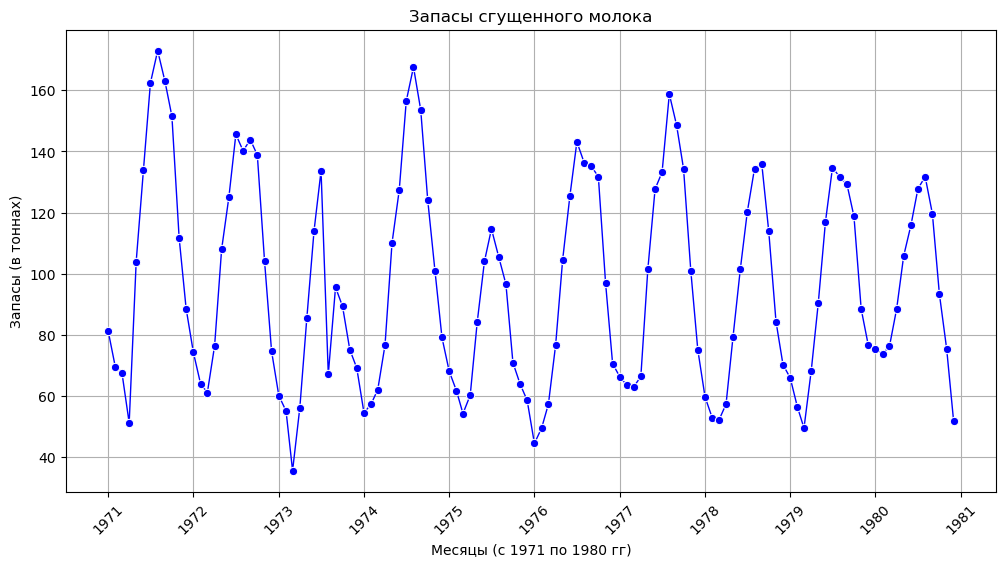

In [12]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=condmilk_df['v1'], marker='o', color='b', linewidth=1)
plt.title("Запасы сгущенного молока")
plt.xlabel("Месяцы (с 1971 по 1980 гг)")
plt.ylabel("Запасы (в тоннах)")
plt.xticks(rotation=45)
plt.grid()
plt.show()

По внешнему виду графика можно предположить, что ряд обладает сезонностью, тренд на нем явно не прослеживается. Проверим эти гипотезы с помощью сезонной декомпозиции

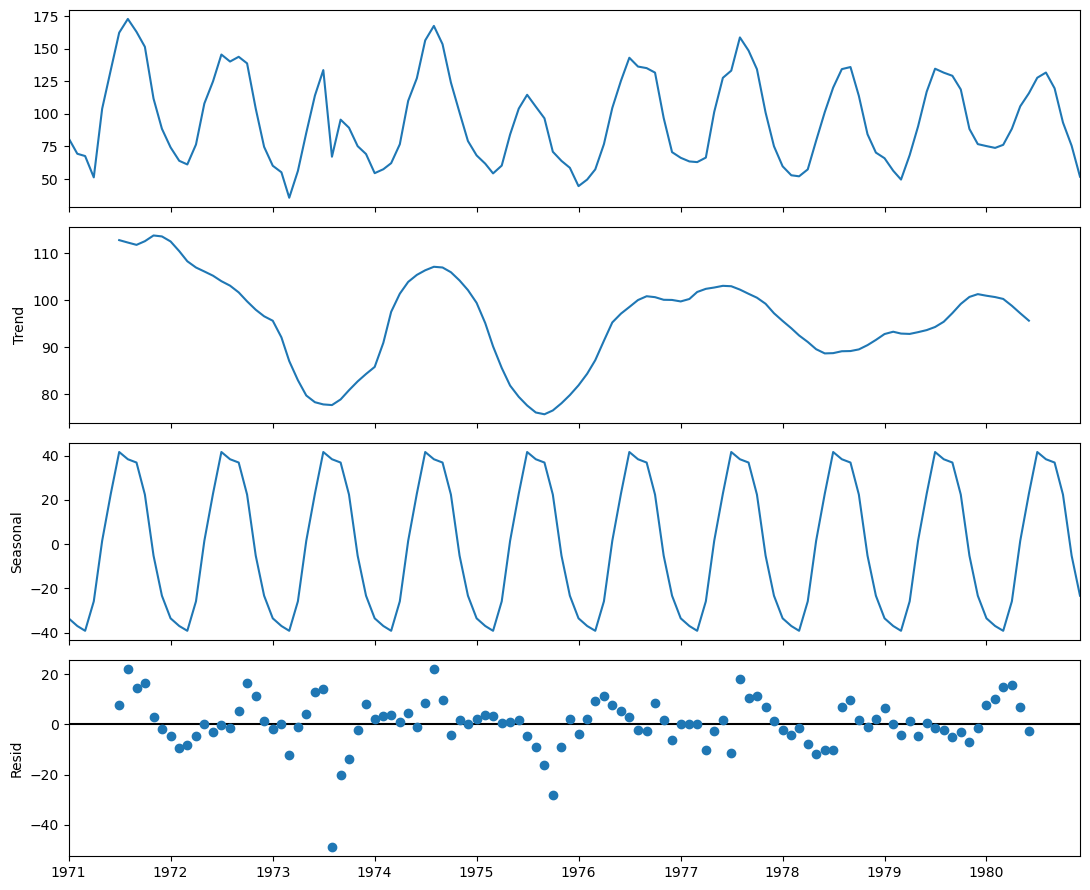

In [13]:
decomposition = seasonal_decompose(condmilk_df)
decomposition.plot()
plt.show()

На графиках явно выражена сезонность с периодом примерно в 12 месяцев, что может быть предположительным количеством лагов, на основе которых мы будем прогнозировать новые значения ряда (делаем прогноз на 1 месяц вперед по информации за предшествующий год)

Также мы видим колеблющийся тренд с глобальным убыванием. Проверим его наличие и значимость с помощью критерия Фостера-Стюарта

In [14]:
foster_stuart_criterion(condmilk_df.v1.to_numpy())

0.0

Всего у нас 120 наблюдений, следовательно число степеней свободы n = 119, уровень значимости равен 0.05, табличное значение критерия Фостера-Стюарта примерно равно 1.98

Сравнивая с табличным значением принимаем решение о принятии гипотезы $H_0$ (об отсутствии изменения тренда), следовательно, можно согласиться с гипотезой об отсутствии тренда

Если посмотреть на график остатков, можно предположить, что минимальное значения ряда является выбросом. Проверим это с помощью [правила 3-х сигм](https://wiki.loginom.ru/articles/3-sigma-rule.html)

In [15]:
mean_v1 = np.mean(condmilk_df.v1)
std_v1 = np.std(condmilk_df.v1)

In [16]:
lower_outlier_threshold = mean_v1 - 3 * std_v1
lower_outlier_threshold

-5.036510185643692

In [17]:
upper_outlier_threshold = mean_v1 + 3 * std_v1
upper_outlier_threshold

196.69351018564367

In [18]:
lower_outlier_threshold <= np.min(condmilk_df.v1) <= upper_outlier_threshold

True

Как видно, минимальное значения ряда выбросом **НЕ** является

Также проверим максимальное значение

In [19]:
lower_outlier_threshold <= np.max(condmilk_df.v1) <= upper_outlier_threshold

True

Максимальное значение ряда тоже не является выбросом, поэтому дополнительная обработка значений ряда с целью избавления от выбросов не требуется

Для интереса проверим, являются минимум и максимум в остатках выбросами

In [20]:
mean_resid = np.mean(decomposition.resid)
std_resid = np.std(decomposition.resid)

In [21]:
lower_resid_threshold = mean_resid - 3 * std_resid
lower_resid_threshold

-28.239600427243722

In [22]:
upper_resid_threshold = mean_resid + 3 * std_resid
upper_resid_threshold

29.49071925440422

In [23]:
lower_resid_threshold <= np.min(decomposition.resid) <= upper_resid_threshold

False

In [24]:
lower_resid_threshold <= np.max(decomposition.resid) <= upper_resid_threshold

True

Как видно, только минимальное значение остатков является выбросом, но сам ряд их не имеет, поэтому сразу перейдем к построению модели линейной регрессии

## Feature engineering для построения модели линейной регрессии

Добавим каждой записи временной индекс, который будет отличать их друг от друга 

In [25]:
condmilk_df['time_index'] = np.arange(len(condmilk_df))
condmilk_df.head(10)

,v1,time_index
1971-01-01,81.28,0
1971-02-01,69.39,1
1971-03-01,67.63,2
1971-04-01,51.25,3
1971-05-01,103.97,4
1971-06-01,133.83,5
1971-07-01,162.37,6
1971-08-01,172.91,7
1971-09-01,163.01,8
1971-10-01,151.50,9


На прошлом шаге мы заметили, что период сезонности составляет примерно 12 месяцев. Преобразуем данные так, чтобы при предсказании целевого значения на следующий месяц можно было опираться на данные о 12 предыдущих

Для этого добавим в датафрейм 12 лаг-столбцов, каждый из которых будет представлять соответствующий лаг для текущей записи

In [26]:
LAGS = 12

In [27]:
lags = pd.DataFrame({f'lag_{i}': condmilk_df['v1'].shift(i) for i in range(1, LAGS + 1)})
lags

,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1971-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-02-01,81.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-03-01,69.39,81.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-04-01,67.63,69.39,81.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1971-05-01,51.25,67.63,69.39,81.28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
1980-08-01,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77,129.25,131.67
1980-09-01,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77,129.25
1980-10-01,119.63,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77
1980-11-01,93.38,119.63,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44


Объединим лаги и исходный датасет, отбросив строки с пропусками (первые 12)

In [28]:
condmilk_df = pd.concat([condmilk_df, lags], axis=1).dropna()
condmilk_df

,v1,time_index,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12
1972-01-01,74.29,12,88.58,111.73,151.50,163.01,172.91,162.37,133.83,103.97,51.25,67.63,69.39,81.28
1972-02-01,63.98,13,74.29,88.58,111.73,151.50,163.01,172.91,162.37,133.83,103.97,51.25,67.63,69.39
1972-03-01,61.18,14,63.98,74.29,88.58,111.73,151.50,163.01,172.91,162.37,133.83,103.97,51.25,67.63
1972-04-01,76.48,15,61.18,63.98,74.29,88.58,111.73,151.50,163.01,172.91,162.37,133.83,103.97,51.25
1972-05-01,107.98,16,76.48,61.18,63.98,74.29,88.58,111.73,151.50,163.01,172.91,162.37,133.83,103.97
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980-08-01,131.75,115,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77,129.25,131.67
1980-09-01,119.63,116,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77,129.25
1980-10-01,93.38,117,119.63,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44,118.77
1980-11-01,75.55,118,93.38,119.63,131.75,127.76,115.84,105.83,88.58,76.24,73.89,75.28,76.79,88.44


Теперь данные готовы к построению модели линейной регрессии

## Построение модели линейной регрессии

Выделим целевую и переменные-признаки

In [29]:
X = condmilk_df.drop('v1', axis=1)
y = condmilk_df['v1']

Разобьем данные на тренировочную и тестовую выборки в соотношении 80/20

In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Построим модель линейной регрессии и обучим ее

In [31]:
model = LinearRegression()
model.fit(X_train, y_train)

model.get_params()

{'copy_X': True, 'fit_intercept': True, 'n_jobs': None, 'positive': False}

Посмотрим на формулу, которую представляет модель

In [32]:
formula = get_model_formula(model)
print(formula)

30.517216241548475 - 0.01327240042261576 * time_index + 0.9284497928775013 * lag_1 - 0.11297500856403508 * lag_2 + 0.005533474354200302 * lag_3 - 0.15785897895800727 * lag_4 + 0.1331474879781219 * lag_5 - 0.4320631391615768 * lag_6 + 0.2284513161869103 * lag_7 + 0.022119146260292568 * lag_8 + 0.002996881446811516 * lag_9 + 0.038642408556144106 * lag_10 + 0.15326690287669045 * lag_11 - 0.1271819704461765 * lag_12


Как видно, наибольшую значимость имеет 1-й лаг, также достаточно большой отрицательный коэффициент расположен возле 6-го, что говорит об изменении направления графика функции каждые 6 месяцев, что подтверждает гипотезу о годичной периодичности у сезонности. Остальные лаги влияют на модель слабее 

Построим прогноз модели на тестовой выборке

In [33]:
y_pred = model.predict(X_test)
y_pred

array([ 56.47255325,  63.37285056,  89.3288912 , 108.02877448,
       128.02952261, 137.96424116, 128.19899186, 112.95963612,
       100.27343804,  70.72006293,  61.08862342,  69.04885659,
        76.65800965,  82.75487591, 105.2433074 , 116.93315284,
       118.2671611 , 126.16573364, 123.61398619, 104.08374519,
        77.96846285,  66.34906974])

А также восстановим ряд из тренировочной выборки с помощью модели

In [34]:
y_restored = model.predict(X_train)
y_restored

array([ 63.88968521,  56.89697676,  60.69984938,  71.87915593,
        98.84454029, 127.67464056, 136.60539568, 148.44113573,
       134.7005894 , 127.25242588, 111.87928653,  84.33291592,
        55.52015443,  55.40058037,  58.64278895,  47.47426675,
        80.42928333, 109.44808214, 130.73026457, 139.10090783,
        77.72165522,  91.78963621,  74.1201645 ,  70.96988042,
        52.67108145,  76.7523347 ,  62.36904075,  76.08066443,
        97.0816759 , 120.13004534, 125.2420582 , 156.53668373,
       153.50991583, 134.30157737,  95.60771397,  78.6131411 ,
        59.18122795,  57.26637206,  64.40756349,  72.28711318,
        79.99862536, 107.10033217, 119.84998605, 120.61274469,
       105.91599647,  93.62950936,  61.75130551,  58.72761486,
        55.2863476 ,  52.39028167,  61.18420615,  80.21933307,
        96.21903081, 116.04528822, 133.33487826, 138.79646547,
       123.19447532, 118.8089047 , 107.8063344 ,  75.77421596,
        55.25671194,  63.18242766,  68.43172128,  71.45

Построим на одном графике исходный ряд и прогнозы модели на тренировочной выборке (восстановленный ряд) и тестовой

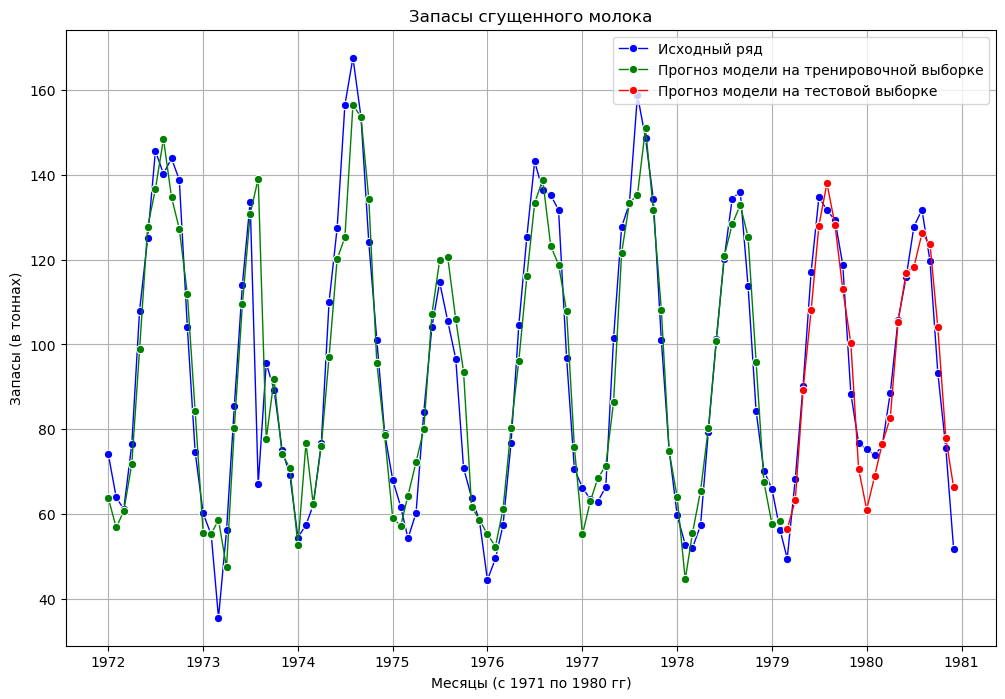

In [35]:
plt.figure(figsize=(12, 8))
sns.lineplot(x=condmilk_df.index, y=condmilk_df['v1'], marker='o', color='blue', label='Исходный ряд', linewidth=1)
sns.lineplot(x=X_train.index, y=y_restored, marker='o', color='green', label='Прогноз модели на тренировочной выборке', 
             linewidth=1)
sns.lineplot(x=X_test.index, y=y_pred, marker='o', color='red', label='Прогноз модели на тестовой выборке', linewidth=1)
plt.title("Запасы сгущенного молока")
plt.xlabel("Месяцы (с 1971 по 1980 гг)")
plt.ylabel("Запасы (в тоннах)")
plt.legend()
plt.grid()
plt.show()

Как видим, график прогнозов модели находится достаточно близко к исходному, что говорит о достаточно высоком качестве модели 

Оценим модель с помощью средней абсолютной и средней квадратичной ошибок, а также с помощью коэффициента детерминации $R^2$

Оценим работу модели на тренировочной выборке

In [36]:
train_mae = mean_absolute_error(y_train, y_restored)
train_mse = mean_squared_error(y_train, y_restored)

print(f"MAE на тренировочной выборке: {train_mae}")
print(f"MSE на тренировочной выборке: {train_mse}")

MAE на тренировочной выборке: 7.838194263771086
MSE на тренировочной выборке: 145.54977724802959


In [37]:
train_r2 = model.score(X_train, y_train)
print(f"Коэффициент детерминации R2 на тренировочной выборке: {train_r2}")

Коэффициент детерминации R2 на тренировочной выборке: 0.8698630077663341


На тренировочной выборке модель отработала достаточно хорошо, единственным местом, где она сильно ошиблась стал минимум временного ряда, который был предполагаемым выбросом

Оценим работу модели на тестовой выборке

In [38]:
test_mae = mean_absolute_error(y_test, y_pred)
test_mse = mean_squared_error(y_test, y_pred)

print(f"MAE на тестовой выборке: {test_mae}")
print(f"MSE на тестовой выборке: {test_mse}")

MAE на тестовой выборке: 6.059062322644951
MSE на тестовой выборке: 53.65983216698236


In [39]:
test_r2 = model.score(X_test, y_test)
print(f"Коэффициент детерминации R2 на тестовой выборке: {test_r2}")

Коэффициент детерминации R2 на тестовой выборке: 0.9226328121592883


На тестовой выборке модель отработала лучше, что может быть следствием небольшого числа данных в выборке и отсутствием  возможных выбросов в ней

## Построение прогноза модели

Согласно заданию из описания датасета - необходимо построить прогноз на следующие 8 месяцев

Установим горизонт планирования

In [40]:
forecast_horizon = 8

Выделим столбцы-лаги

In [41]:
lag_columns = [f'lag_{i}' for i in range(1, LAGS + 1)]
lag_columns

['lag_1',
 'lag_2',
 'lag_3',
 'lag_4',
 'lag_5',
 'lag_6',
 'lag_7',
 'lag_8',
 'lag_9',
 'lag_10',
 'lag_11',
 'lag_12']

Построим прогноз и визуализируем его

In [42]:
forecast = forecast_timeseries(model=model, historical_data=condmilk_df, horizon=forecast_horizon, 
                               time_column='time_index', lag_columns=lag_columns)
forecast

,time_index,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,predicted
0,120,75.55,93.38,119.63,131.75,127.76,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797
1,121,93.38,119.63,131.75,127.76,115.84,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902
2,122,119.63,131.75,127.76,115.84,105.83,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283
3,123,131.75,127.76,115.84,105.83,88.58,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024
4,124,127.76,115.84,105.83,88.58,76.24,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842
5,125,115.84,105.83,88.58,76.24,73.89,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872
6,126,105.83,88.58,76.24,73.89,75.28,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850
7,127,88.58,76.24,73.89,75.28,76.79,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850,102.443566


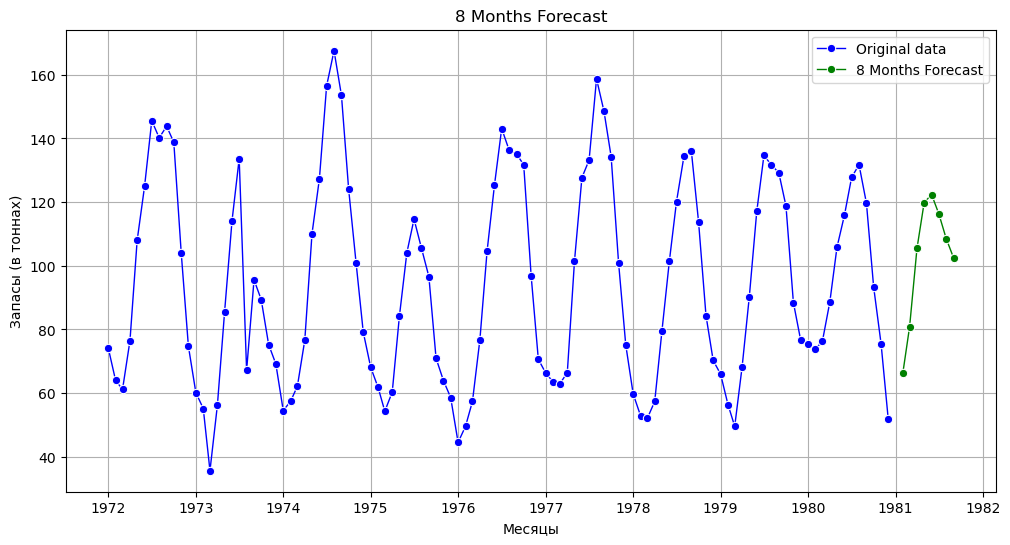

In [43]:
show_forecast_result(historical_data=condmilk_df, horizon=forecast_horizon, predicting_column='v1', forecast=forecast, 
                     xlabel='Месяцы', ylabel='Запасы (в тоннах)')

Как видно, прогноз выглядит достаточно адекватно, результаты демонстрируют сезонность модели и смену направления движения графика около 6-го месяца относительно последней известной нам точки, что говорит о достаточно высоком качестве модели

Построим более длинный прогноз чтобы посмотреть, насколько модель справилась с сезонностью в данных

In [44]:
forecast_horizon = 24

In [45]:
forecast = forecast_timeseries(model=model, historical_data=condmilk_df, horizon=forecast_horizon, 
                               time_column='time_index', lag_columns=lag_columns)
forecast

,time_index,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,predicted
0,120,75.550000,93.380000,119.630000,131.750000,127.760000,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797
1,121,93.380000,119.630000,131.750000,127.760000,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902
2,122,119.630000,131.750000,127.760000,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283
3,123,131.750000,127.760000,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024
4,124,127.760000,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842
5,125,115.840000,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872
6,126,105.830000,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850
7,127,88.580000,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850,102.443566
8,128,76.240000,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850,102.443566,88.713176
9,129,73.890000,75.280000,76.790000,66.335797,80.739902,105.466283,119.863024,122.366842,116.356872,108.542850,102.443566,88.713176,83.089981


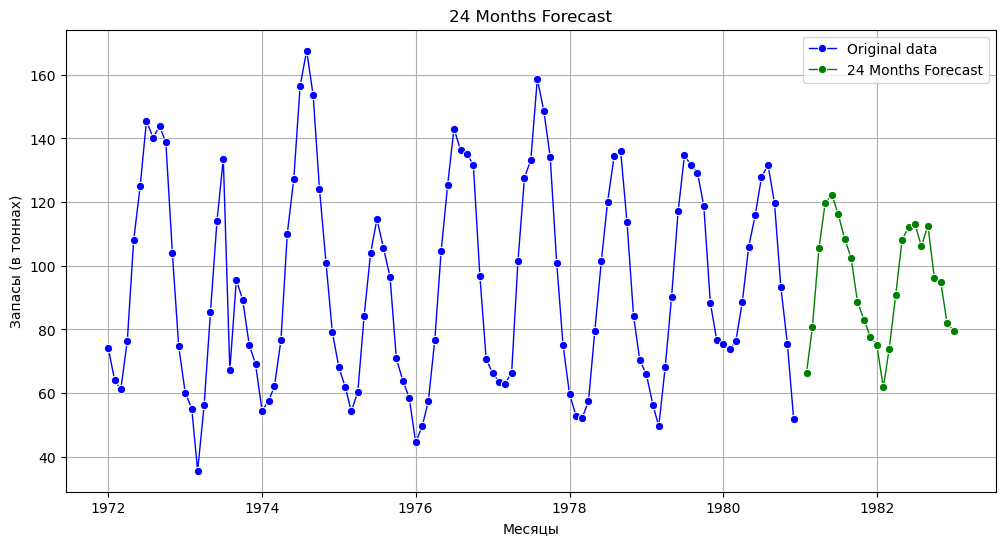

In [46]:
show_forecast_result(historical_data=condmilk_df, horizon=forecast_horizon, predicting_column='v1', forecast=forecast, 
                     xlabel='Месяцы', ylabel='Запасы (в тоннах)')

Как видно, модель хорошо изучила сезонную составляющую в данных, также можно заметить уменьшение амплитуды колебаний, что может быть следствием глобально убывающего тренда. Кроме того мы можем заметить уменьшение амплитуды, начинающееся с 1978 года, что также объясняет поведение модели